#### Import libraries and modules

In [1]:
# data imports and manipulation
import numpy as np
import pandas as pd
from PIL import Image

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from plotly import express as px
from plotly import figure_factory as ff
from PIL import ImageFont


# sklearn preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,accuracy_score, recall_score, roc_auc_score, precision_score

# tensorflow model and metrics
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import FalseNegatives, AUC, Precision
import visualkeras

**Import model and data**

In [2]:
cnn = load_model('../models/model_03_auc93/')

In [3]:
X_train = np.load('../data/X_train.npy')
X_test = np.load('../data/X_test.npy')
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

In [4]:
preds = cnn.predict(X_test)

**Plot distribution of predicted probabilities to get a sense of how separated the two groups are**

In [5]:
# create dataframe to make plotting easier
predictions_df = pd.DataFrame(y_test, columns=['label'])
predictions_df['preds'] = preds

In [6]:
predictions_df.head(1)

,label,preds
0,0,0.005394


In [7]:
# replace 1 and 0 with strings indicating class
predictions_df['label'].replace({1:'Glaucoma', 0:'Healthy'}, inplace=True)

# uncomment below to save predictions to file
# predictions_df.to_csv('../data/test_predictions.csv', index=False)

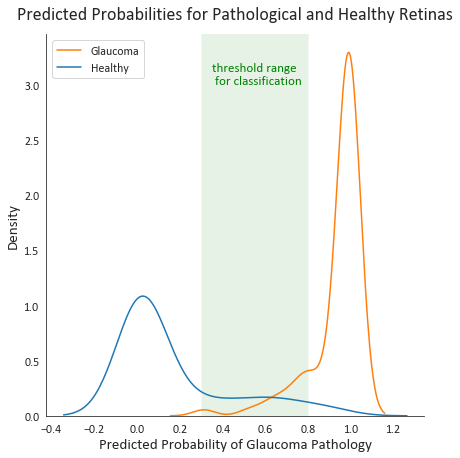

In [8]:
predictions_df = pd.read_csv('../data/test_predictions.csv')

sns.set_style('white')

# establish palette so Glaucoma is always orange
palette = {"Healthy":"tab:blue",
           "Glaucoma":"tab:orange"}

# set up font for plot
plt.rcParams.update({'font.sans-serif':'Calibri'})


sns.displot(data=predictions_df, 
            x='preds', 
            hue='label', 
            kind='kde',    # plot histogram
            # binwidth=0.1, 
            # kde=True,       # also plot kde
            # element='step', # plot histogram as step
            height=6, 
            legend=False,   # don't plot legend
            palette=palette,# use palette to assign colors
            # edgecolor=None # don't draw dark line around histogram);
           )

# labels and title
plt.legend(['Glaucoma', 'Healthy'], fontsize=12)
plt.xlabel('Predicted Probability of Glaucoma Pathology', size=15)
plt.ylabel('Density', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Predicted Probabilities for Pathological and Healthy Retinas', size=18, y=1, pad=15);

# generate a rectangle area where the potential threshold for predicted probability would be 
left, bottom, width, height = (0.3, 0, 0.5, 3.5)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.1,
                       facecolor="green")
plt.gca().add_patch(rect)
plt.text(0.35, 3,'threshold range\n for classification',fontsize=13, color="green");


# uncomment below to save figure
plt.savefig('../figures/prob_distribution.png', bbox_inches='tight', dpi=300)

In [17]:
print(sns.color_palette().as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


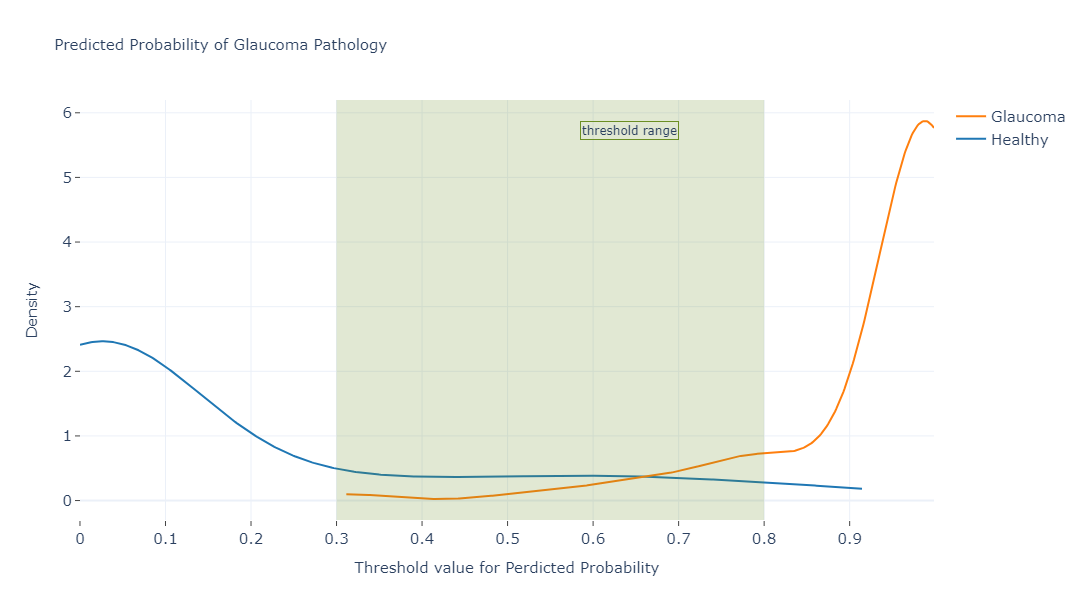

In [34]:
hist_data = [predictions_df[predictions_df['label']=='Healthy']['preds'], predictions_df[predictions_df['label']=='Glaucoma']['preds']]
group_labels = ['Healthy', 'Glaucoma']
colors = ['#1f77b4', '#ff7f0e']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False, colors=colors)

# Add title
fig.update_layout(width=500,
                  height=600,
                  title_text='Predicted Probability of Glaucoma Pathology',
                  plot_bgcolor='white',
                  template='plotly_white',
                  legend=dict(font=dict(size=15)),
                  title_font=dict(size=15))

fig.update_xaxes(title='Threshold value for Perdicted Probability', title_font_size=15, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Density', title_font_size=15, tickfont_size=15, ticks='outside')

fig.add_vrect(x0=0.3, x1=0.8, 
              line_width=0, 
              fillcolor="olivedrab", 
              opacity=0.2, 
              annotation=dict(text='threshold range', 
                              x=0.7, y=0.95, 
                              bordercolor='olivedrab'))
fig.show()

**Determine what the optimal threshold for predicted probability is that maximizes performance metrics of the model**

First, I calculate all metrics (recall (for false-negatives), precision(for false-positives), accuracy (for overall classifictation since classes are more or less balanced), and auc_roc), for all values of threshold between 0.3 and 0.8. I picked these values because this is the area inbetween the two curves. 

In [9]:
recall = []
precision = []
auc = []
accuracy = []
thresh = []
for th in np.linspace(0.3, 0.8, 20):
    y_pred = [0 if p<th else 1 for p in preds]
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    auc.append(roc_auc_score(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))
    thresh.append(th)
metrics_df = pd.DataFrame(dict(threshold=thresh,
                              recall=recall,
                              precision=precision,
                              auc=auc,
                              accuracy=accuracy))

Visualize the dataframe of values

In [97]:
metrics_df.sort_values('auc', ascending=False).head()

,threshold,recall,precision,auc,accuracy
12,0.615789,0.962025,0.926829,0.932626,0.936170
17,0.747368,0.911392,0.960000,0.931503,0.929078
11,0.589474,0.974684,0.916667,0.930890,0.936170
16,0.721053,0.924051,0.948052,0.929767,0.929078
15,0.694737,0.936709,0.936709,0.928032,0.929078


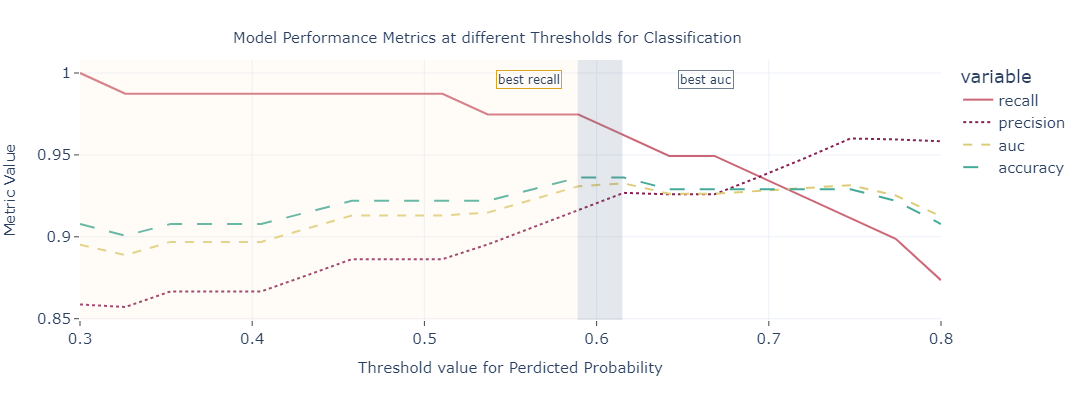

In [35]:
# use melt to convert the dataframe with different columns for each metric into a 
# dataframe with a single column of metric values and a second column of metric labels.
# This makes it easy to plot the data in plotly. 

df = pd.melt(metrics_df, id_vars='threshold', value_vars=metrics_df.columns[:])

# uncomment below to save metrics to file so it can be loaded into streamlit
# df.to_csv('../data/threshold_metrics.csv', index=False)

fig = px.line(df, 
              x='threshold', 
              y='value', 
              color='variable',
              color_discrete_sequence=['#CC6677', '#882255', '#DDCC77', '#44AA99'],
              line_dash='variable'
              )

fig.update_layout(width=600, 
                  height=400,
                  title_text='Model Performance Metrics at different Thresholds for Classification',
                  title_y=0.92,
                  title_x=0.45,
                  plot_bgcolor='white',
                  template='plotly_white',
                  # margin=dict(l=10, r=0, t=60, b=10),
                  # paper_bgcolor="lightsteelblue",
                  legend=dict(font=dict(size=15)),
                  title_font=dict(size=15)
                 )

# set axes labels
fig.update_xaxes(title='Threshold value for Perdicted Probability', title_font_size=15, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Metric Value', title_font_size=15, tickfont_size=15, ticks='outside')

fig.update_traces(mode="lines", hovertemplate=None)
fig.update_layout(hovermode="x")

# add retangles
fig.add_vrect(x0=0.3, x1=0.589, line_width=0, fillcolor="papayawhip", opacity=0.2, annotation=dict(text='best recall', x=0.58, y=0.96, bordercolor='goldenrod'))
fig.add_vrect(x0=0.589, x1=0.615, line_width=0, fillcolor="lightslategray", opacity=0.2, annotation=dict(text='best auc', x=0.68, y=0.96, bordercolor='slategrey'))

fig.show()

**Pick a threshold using the interactive plotly plot**
From the figure above, best threshold appears to be **0.589** which is where best auc and accuracy scores overlap with recall

In [36]:
# generate a y_pred variable which is 0 (or Healthy) for all observations that have a predicted probability of less than the threshold
# and a value of 1 (or Glaucoma) for all observations with a predicted probability of greater than the threshold
y_pred = [0 if p<0.589 else 1 for p in preds]
y_pred_train = [0 if p<0.589 else 1 for p in cnn.predict(X_train)]

In [37]:
# calculate metrics for test and train sets

pd.DataFrame(index=['recall', 'accuracy', 'roc_auc', 'precision'], 
             data={'test set': [recall_score(y_test, y_pred),
                        accuracy_score(y_test, y_pred),
                        roc_auc_score(y_test, y_pred),
                        precision_score(y_test, y_pred)],
                  'train set': [recall_score(y_train, y_pred_train),
                        accuracy_score(y_train, y_pred_train),
                        roc_auc_score(y_train, y_train),
                        precision_score(y_train, y_train)]})

,test set,train set
recall,0.974684,0.911672
accuracy,0.936170,0.932624
roc_auc,0.930890,1.000000
precision,0.916667,1.000000


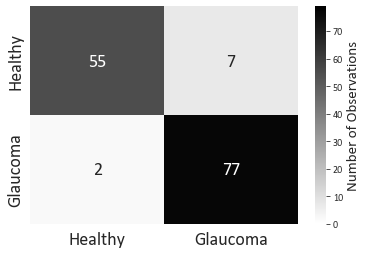

In [38]:
fig = sns.heatmap(confusion_matrix(y_test, y_pred), 
                  annot=True, 
                  annot_kws={"size": 18},
                  cbar_kws={'label': 'Number of Observations'},
                  xticklabels=['Healthy', 'Glaucoma'], 
                  yticklabels=['Healthy', 'Glaucoma'],
                  vmin=0, vmax=79, 
                  cmap='binary');

fig.figure.axes[-1].yaxis.label.set_size(15)
fig.set_xticklabels(fig.get_xmajorticklabels(), fontsize = 18)
fig.set_yticklabels(fig.get_ymajorticklabels(), fontsize = 18);

In [54]:
# np.save('../data/confusion_matrix.npy', confusion_matrix(y_test, y_pred))

In [74]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred).ravel(), columns=['Count'])
cm['Class'] = ['True', 'False', 'False', 'True']
cm

,Count,Class
0,55,True
1,7,False
2,2,False
3,77,True


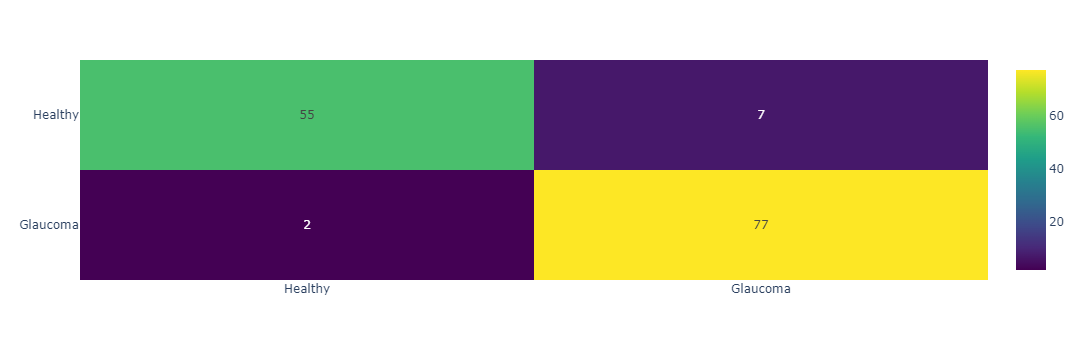

In [78]:
z=confusion_matrix(y_test, y_pred)
x=['Healthy', 'Glaucoma']
y=['Healthy', 'Glaucoma']

z_text = [[str(y) for y in x] for x in z]
fig = px.imshow(z, x=x, y=y, color_continuous_scale='Viridis', aspect="auto")
fig.update_traces(
    text=z_text, texttemplate="%{text}", textfont_size=12)
fig.update_traces(customdata = custom_data,
                  hovertemplate='<br>'.join([
                        'Predicted: %{x}',
                        'True: %{y}',
                        'Count: %{z}'
                    ]))

fig.update_layout(width=300, height=300)

In [56]:
[str(y) for y in x]

['Healthy', 'Glaucoma']

**Make a prediction on an image the model has never seen before and is not part of the original dataset**

In [30]:
glauc = predictions_df[predictions_df['label']=='Glaucoma']['preds']
healthy = predictions_df[predictions_df['label']=='Healthy']['preds']

In [31]:
# to plot a point, we know the probability value for the figure, ex 0.2

def find_y(val, fig):
    threshold = 0.589 # threshold of predicted probability for classification
    if val > threshold: # model would predict as 'Glaucoma'
        arr_0 = np.array(fig.data[0]['x'])
        ind_0 = abs(val - arr_0).argmin()
        # min_0 = arr_0[ind_0]
        y = fig.data[0]['y'][ind_0] 
    else:    # model would predict as 'Healthy'
        arr_1 = np.array(fig.data[1]['x'])
        ind_1 = abs(val - arr_1).argmin()
        # min_1 = arr_1[ind_1]
        y = fig.data[1]['y'][ind_1]
    
    return y

0.6199856

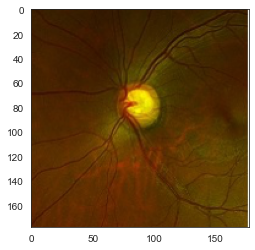

In [38]:
# make prediction on new image that the model has not seen
sns.set_style('white')
img = '../data/test_images/LA_left_eye.jpg'
image_data = np.asarray(Image.open(img).resize((178,178))) # resize to a size the network can accept and convert to np.array
image_data = image_data.astype('float32')/255 # normalize pixel values to [0, 1]
plt.imshow(image_data)
image_data = image_data.reshape(1, 178, 178, 3) # reshape array to appropriate shape for network 
prediction = cnn.predict(image_data)[0][0]
prediction

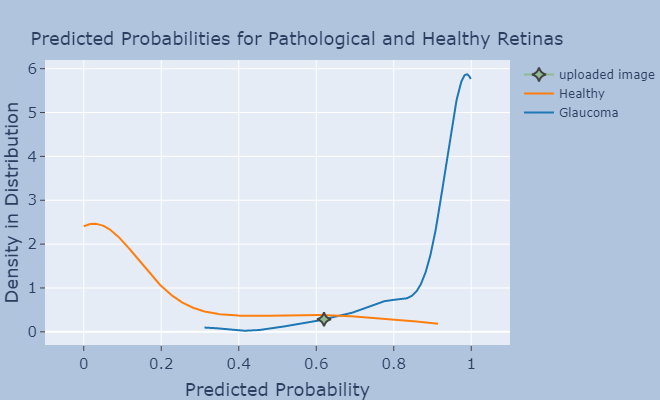

In [42]:
var = [glauc, healthy]
labels = ['Glaucoma', 'Healthy']

# generate figure using true labels
fig = ff.create_distplot(var, 
                         labels,
                         # bin_size=0.01,
                         show_hist=False, 
                         show_rug=False)
# set size and title
fig.update_layout(width=600, 
                  height=400,
                  title_text='Predicted Probabilities for Pathological and Healthy Retinas',
                  title_y=0.92,
                  title_x=0.45,
                  xaxis_range=[-0.1, 1.1],
                  margin=dict(l=30, r=0, t=60, b=10),
                  paper_bgcolor="lightsteelblue",
                  legend=dict(font=dict(size=12)),
                  title_font=dict(size=18)
                 )

# set axes labels
fig.update_xaxes(title='Predicted Probability', title_font_size=18, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Density in Distribution', title_font_size=18, tickfont_size=15, ticks='outside')

# add marker at position matching predicted probability of the uploaded image 
fig.add_scatter(x=[round(prediction, 2)], 
                y=[find_y(round(prediction, 2),fig)], # use helper function 'find_y' to determine what the y coordinate for the marker should be
                name='uploaded image', 
                marker=dict(size=10, 
                            line=dict(width=2),
                            color='darkseagreen', 
                            symbol="star-diamond"))



fig.show()

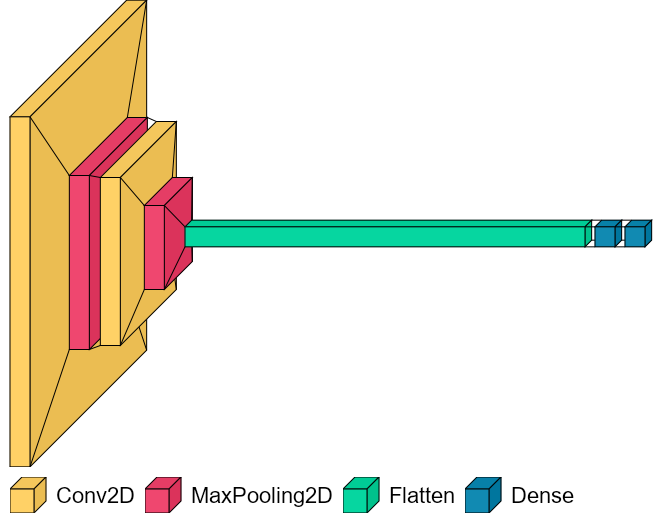

In [62]:
# visualize model
font = ImageFont.truetype("arial.ttf", 22)  
visualkeras.layered_view(cnn, 
                         scale_xy=2,
                         legend=True, 
                         font=font,
                         to_file='../figures/model_03_auc93.png')  